In [1]:
# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# diversity picker
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

# plots
from matplotlib import pyplot
import seaborn

# scikit learn
# conda install -c conda-forge scikit-learn 
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing

# other packages
import pandas as pd
import csv
import re

RDKit WARNING: [21:47:06] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# some pChEMBL values in our file are not valid floats
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

In [3]:
# function for Lipinski's descriptors
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

In [4]:
# load mtor, we want to remember source of data and pChEMBLE value (it's transfomed compound activity to "standard" value)
with open("../bojicm/compound/chembl395.csv") as inp:
    mtor = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in mtor:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["source"] = "hepg2"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)
        for f in lip_func:
            m[f[0]] = f[1](m["rdmol"])

In [5]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
drugbank = [{"rdmol": m,
             "source": "drugbank",
             "Smiles": Chem.MolToSmiles(m),
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             **{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ]

In [6]:
# let's work with Pandas dataframe
df = pd.DataFrame((*drugbank, *mtor), columns=["Smiles", "source", "rdmol", "fps", "pChEMBL_value", *(f[0] for f in lip_func)])
# adds index as normal column
df.reset_index(level=0, inplace=True)

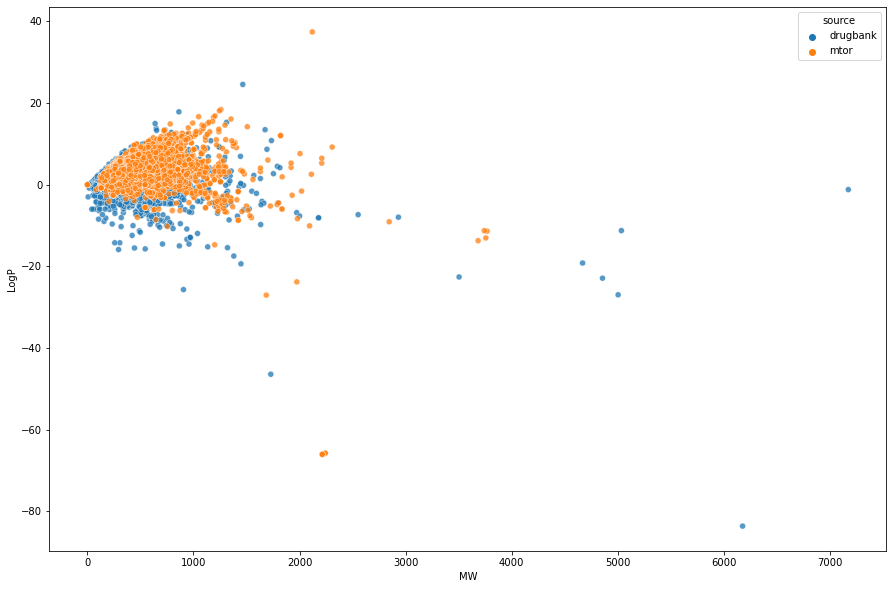

In [7]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MW",
                      y="LogP",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

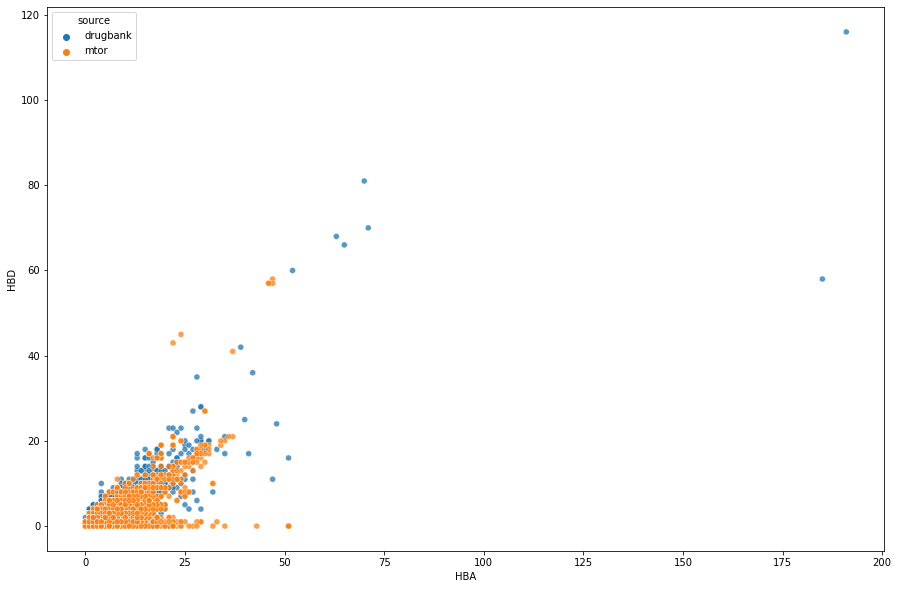

In [8]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="HBA",
                      y="HBD",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [9]:
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

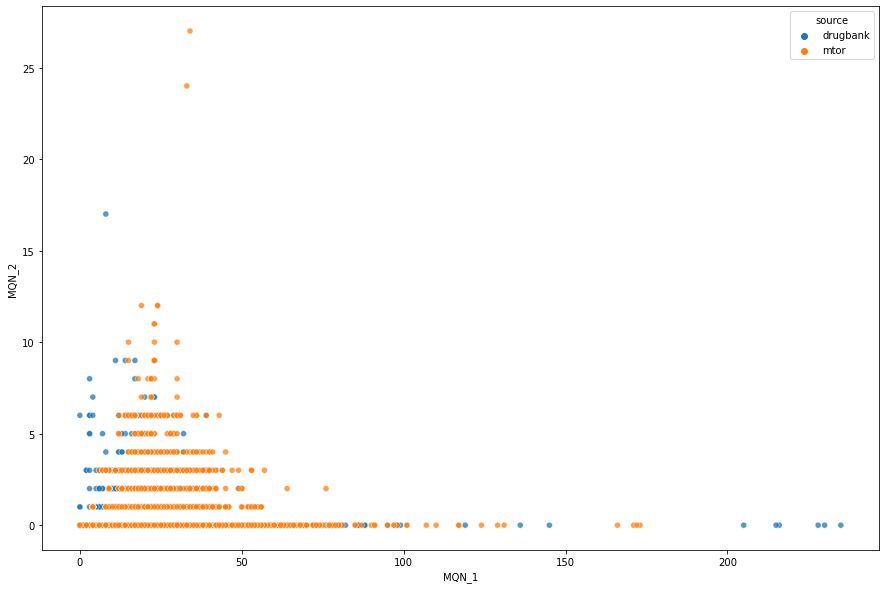

In [10]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="MQN_1",
                      y="MQN_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

**PCA**

In [11]:
pca = decomposition.PCA(n_components=42)
pca.fit(df[(f"MQN_{x}" for x in range(1, 43))])
df = df.join(pd.DataFrame(pca.transform(df[(f"MQN_{x}" for x in range(1, 43))]),
                          columns=[f"PCA_{x}" for x in range(1, 43)])
            )

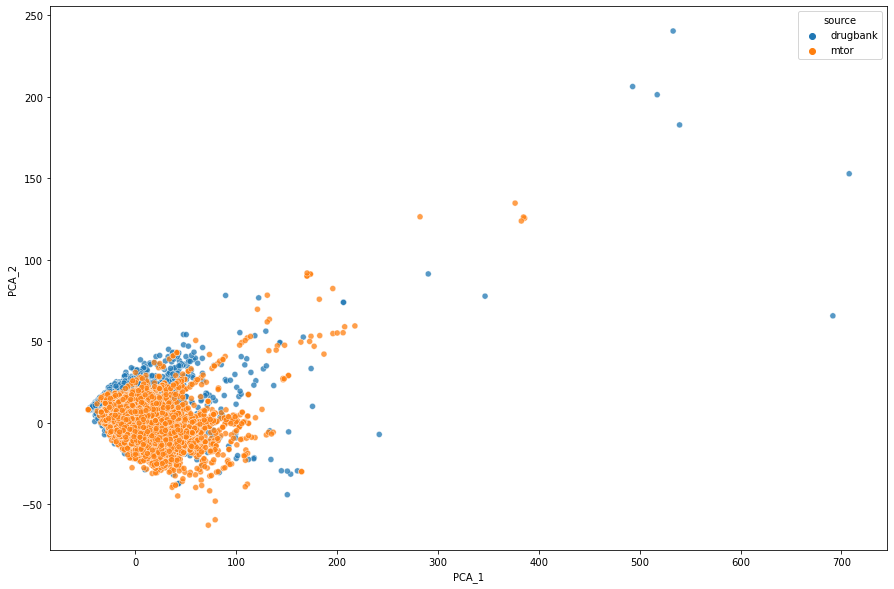

In [12]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1", y="PCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

It looks good but ... do you remember the sentence about variance and PCA? When we multiply some variably by 100, its variance will be also multiplied by 100. Thus, you may want to normalize (or to do something similar) all variables to make them comparable.

In [13]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

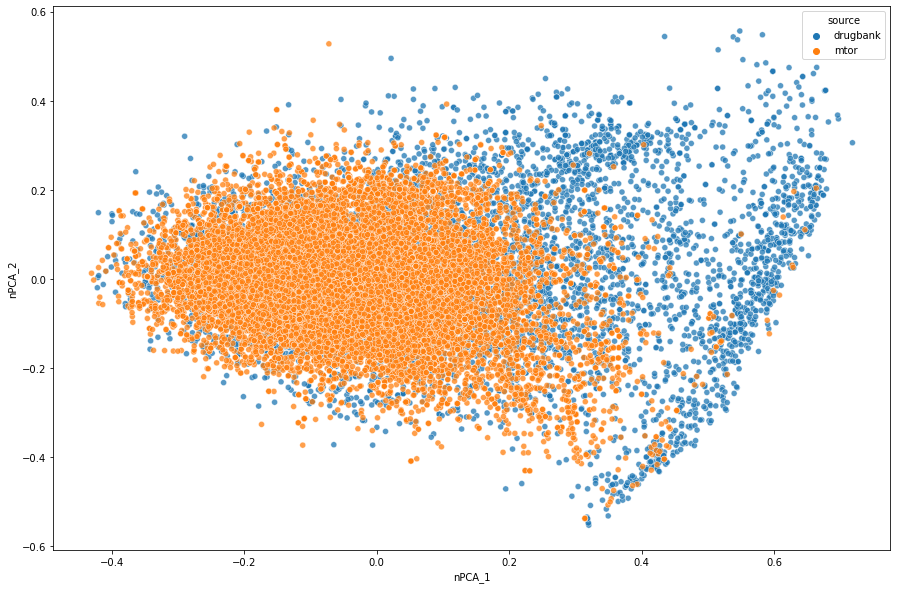

In [14]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

**MDS**

Multidimensional scaling puts instances to lower dimensional space (typically 2D/3D). Method is iterative and tries to keep similar distances between points in the original and new spaces. 

In [ ]:
sparse_mat = distance.pdist(list(df["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
X_mds = clf.fit_transform(dist_mat)

In [ ]:
df = df.join(pd.DataFrame(X_mds, columns=["mds_x","mds_y"]))

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

**t-SNE**

t-distributed stochastic neighbor embedding is another popular method to show similar instances close together and dissimilar far. We can recycle distances calculated for MDS.


In [15]:
clf = manifold.TSNE(n_components=2, metric="precomputed")
X_tsne = clf.fit_transform(dist_mat)

NameError: name 'dist_mat' is not defined

In [ ]:
df = df.join(pd.DataFrame(X_tsne, columns=["tsne_x", "tsne_y"]))

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )  

In [ ]:
def distance_function(index1, index2, *args, fingerprints=df["fps"],
                      metric=DataStructs.TanimotoSimilarity):
    return 1 - DataStructs.FingerprintSimilarity(fingerprints[index1],
                                                 fingerprints[index2],
                                                 metric=metric)

In [ ]:
picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(df), 45))
df["picked"] = df.index.isin(picked)

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("picked"), # True values are drawn as last so they are better visible 
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="PCA_1",
                      y="PCA_2",
                      data=df.sort_values("picked"),
                      hue="picked",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df.sort_values("pChEMBL_value"),
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="mds_x",
                      y="mds_y",
                      data=df[df.source == "hepg2"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df[df.source == "hepg2"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

In [ ]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df[df.source == "hepg2"],
                      hue="pChEMBL_value",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )